Importing Libraries to be used in the notebook

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# Loading Dataset

In [6]:
# Importing train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')
display(train_df.head())
display(test_df.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Exploratory Data Analysis 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The dataset contains three features
- the dataset consist of `15819` rows
- there seems to be no null values


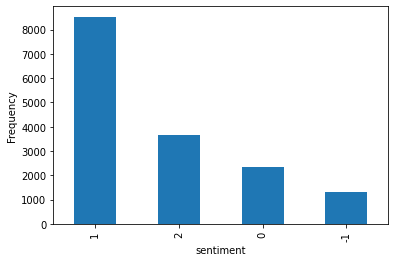

In [8]:
train_df.sentiment.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('sentiment');

Most tweets support the man-made climate change which is represented by `1` while we have a fewer anti-climate change tweets

# Data Cleaning and Wrangling 

### Creating a function to clean the `message`

In [16]:
# creating a function
def cleaning(tweet):
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    rem_link = re.sub(pattern, '', tweet)
    rem_punct = re.sub(r'[^a-zA-Z ]', '', rem_link)
    rem_punct = re.sub(r'RT', '', rem_punct)
    word_split = rem_punct.lower().split()
    stops = set(stopwords.words("english")) # converting to set to make iteration faster
    without_stop_word = ' '.join([x for x in word_split if x not in stops])
    return without_stop_word

In [17]:
train_df['cleaning'] = train_df.message.apply(cleaning)

In [18]:
train_df.head()

,sentiment,message,tweetid,cleaning
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...


In [19]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [22]:
type_label = train_df.sentiment.unique()

In [24]:
personality = {}
for pp in type_label:
    df = train_df.groupby('sentiment')
    personality[pp] = {}
    for row in df.get_group(pp)['cleaning'].str.split():
        personality[pp] = bag_of_words_count(row, personality[pp]) 

In [28]:
all_words = set()
for pp in type_label:
    for word in personality[pp]:
        all_words.add(word)

In [30]:
personality['all'] = {}
for pp in type_label:    
    for word in all_words:
        if word in personality[pp].keys():
            if word in personality['all']:
                personality['all'][word] += personality[pp][word]
            else:
                personality['all'][word] = personality[pp][word]

Text(0.5, 0, 'word frequency')

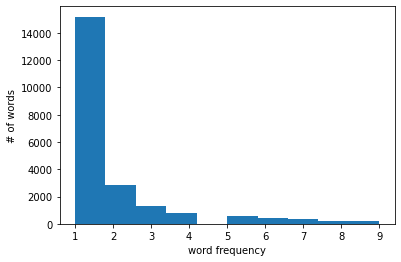

In [35]:
_ = plt.hist([v for v in personality['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

In [36]:
len([v for v in personality['all'].values() if v == 1])

15180

In [37]:
rare_words = [k for k, v in personality['all'].items() if v==1] 
print(rare_words[:100])

['climatecitizensclimate', 'climatesci', 'assassination', 'bokoharam', 'ilmasto', 'sulli', 'implem', 'crazygabey', 'smerconish', 'cehn', 'sarahcandersen', 'laurenkubiak', 'vascopyjama', 'climatefact', 'bernicenot', 'trilliontonne', 'weathermy', 'datalogictruth', 'omickeyyusofine', 'jamiegarwood', 'martinpengelly', 'altpresident', 'projected', 'sciencetrump', 'ajupfront', 'ontrump', 'saltmarsh', 'sureshpprabhurailminindia', 'contemplates', 'tests', 'rlmiller', 'senates', 'contention', 'victimsofcomics', 'ukcip', 'ronlieber', 'clara', 'instagram', 'volatile', 'christianextremist', 'bbylychee', 'wxvybaby', 'senrobportman', 'barstoolbigcat', 'mafucka', 'languagefree', 'yankees', 'ssludgeworth', 'expatina', 'louise', 'repdavidyoung', 'nickconfessore', 'globaldev', 'defo', 'sal', 'floodingbundalangi', 'ramchandani', 'longyearbyen', 'rathers', 'navigate', 'sluggod', 'glaveneel', 'unequal', 'davesperandio', 'faithandclimate', 'leaks', 'whispers', 'eric', 'bushfires', 'whoa', 'harshest', 'aaaaa

In [45]:
# how many words appear more than 10 times?
# how many words of the total does that account for?
print(len([v for v in personality['all'].values() if v >= 10]))
occurs_more_than_10_times = sum([v for v in personality['all'].values() if v >= 5])
print(occurs_more_than_10_times)

2274
144646


In [46]:
total_words = sum([v for v in personality['all'].values()])
occurs_more_than_10_times/total_words

0.8379688903050141

In [49]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,
                             min_df=5,
#                              max_df = 0.5,
#                              ngram_range=(2, 2),
                             max_features = None) 

In [50]:
reviews_vect = vectorizer.fit_transform(train_df['cleaning'])

In [52]:
train_data_features = reviews_vect.toarray() #model work faster with array list
train_data_features.shape

(15819, 3966)

In [55]:
vocab = vectorizer.get_feature_names_out()
vocab

array(['ab', 'abandon', 'abandoning', ..., 'zeroco', 'zinke', 'zone'],
      dtype=object)

In [56]:
import numpy as np

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

6 ab
10 abandon
18 abandoning
34 abc
7 abcnews
6 abcpolitics
7 ability
7 able
20 abortion
5 abou
7 abraham
6 abruptly
20 absolutely
23 abt
14 accelerate
5 accelerated
7 accelerates
12 accelerating
46 accept
7 accepted
5 accepts
13 access
30 accord
32 according
18 account
5 accounts
9 accurate
8 accused
5 acid
12 acknowledge
6 acknowledging
31 across
95 act
19 acting
282 action
38 actions
5 active
6 actively
14 activist
10 activists
6 activities
34 activity
48 actonclimate
15 actual
86 actually
18 ad
5 adambandt
6 adani
20 adapt
34 adaptation
21 adapting
27 add
7 added
103 address
7 addressed
33 addressing
6 adds
6 adjust
38 admin
86 administration
11 administrations
18 administrator
15 admit
16 admits
5 adopt
5 adriennelaf
7 adults
11 advance
5 advice
10 adviser
10 advisor
16 advisory
9 advocate
7 advocates
7 af
5 affairs
45 affect
40 affected
21 affecting
28 affects
13 afford
5 affordable
13 afraid
46 africa
12 african
9 africas
33 ag
52 age
12 agencies
47 agency
63 agenda
5 ages
5 ag

15 drives
23 driving
8 drjillstein
28 drop
7 dropped
5 dropping
7 drops
36 drought
17 droughts
6 drowning
6 drudgerepo
14 drvox
5 dt
16 dude
218 due
22 dumb
7 dumbass
8 dummies
7 dump
23 dup
21 duped
7 dutch
6 dwnews
23 dying
10 earlier
19 early
205 earth
17 earthday
14 earthhour
5 earthjustice
5 earthquakes
27 earths
9 earthtomarrakech
6 easily
13 east
14 easy
11 eat
26 eating
5 eats
13 ebell
5 eclipse
8 eco
25 ecointernet
8 ecological
59 economic
6 economically
5 economics
10 economies
13 economist
67 economy
5 ecosensenow
11 ecosystem
9 ecosystems
9 ed
8 editor
16 editorial
6 educate
40 education
46 effect
19 effective
149 effects
5 efficiency
21 effort
82 efforts
12 eg
5 egypt
37 either
9 el
30 elect
74 elected
72 election
8 electionnight
5 elections
8 electric
6 electricity
10 eliminate
5 eliminates
9 elitists
7 elliegoulding
6 elon
7 elonmusk
27 else
12 em
44 email
52 emails
11 emanuel
7 embassy
5 embrace
13 emergency
67 emissions
15 employees
8 en
5 encyclical
151 end
13 endange

6 kindly
7 king
5 kkk
6 klein
24 knew
282 know
11 knowing
24 knowledge
12 known
92 knows
7 koch
14 korea
5 kp
37 kurteichenwald
5 kwilli
17 kylegriffin
22 la
5 labor
5 labour
23 lack
10 lady
6 ladybird
7 lake
8 lakes
20 land
7 landmark
7 landscapes
6 langenberger
11 language
14 large
9 largely
30 largest
91 last
16 lastweektonight
33 late
16 later
30 latest
26 latimes
5 laughing
11 launch
13 launched
7 launching
28 law
15 lawmakers
24 laws
13 lawson
21 lawsuit
5 le
86 lead
94 leader
137 leaders
44 leadership
81 leading
7 leads
6 leahrboss
5 leak
5 leaked
51 learn
8 learning
35 least
26 leave
16 leaves
9 lecture
25 lectures
5 lecturing
17 led
13 leecamp
68 left
6 lefties
14 legacy
10 legal
10 legislation
11 legit
26 leo
131 leodicaprio
20 leodicaprios
55 leonardo
5 lesbian
62 less
5 lesson
48 let
93 lets
24 letter
56 level
66 levels
35 lgbt
11 lgbtq
7 li
6 liar
5 lib
42 liberal
7 liberalresist
38 liberals
6 liberty
11 libs
22 lie
11 lied
19 lies
49 life
5 lifeaseva
6 lifeblood
7 lifemy


7 remembered
7 remind
37 reminder
20 remove
17 removed
23 removes
9 removing
5 render
29 renewable
20 renewables
6 rep
7 repadamschiff
5 repbarbaralee
5 replaced
5 replacing
117 report
10 reporters
22 reporting
33 reports
8 represent
38 republican
74 republicans
21 request
9 required
5 requires
6 rerouted
6 rescue
142 research
7 researcher
38 researchers
8 researching
5 residents
5 resigns
18 resilience
24 resist
13 resistance
6 resolution
6 resort
8 resource
5 resourceful
60 resources
13 respect
12 respond
9 responds
40 response
8 responses
5 responsibility
25 responsible
32 rest
5 restore
30 result
11 results
10 rethink
11 retreat
11 return
5 returning
17 retweet
12 retweeted
6 reusable
71 reuters
14 reveal
8 revealed
10 reveals
6 reversal
26 reverse
13 reversing
20 review
12 reviews
5 revkin
75 rex
6 rhetoric
20 rich
10 richardbranson
13 richarddawkins
7 richardmunang
29 rick
10 rickygervais
6 rid
14 ridiculous
264 right
122 rights
7 rightwing
6 ring
7 rip
60 rise
57 rising
71 risk


49 york
14 youd
15 youll
33 young
126 youre
16 youth
37 youtube
15 youve
14 yr
18 yrs
6 zach
10 zealand
23 zero
9 zeroco
6 zinke
7 zone


In [58]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)
model.fit(train_data_features, train_df['sentiment'])

RandomForestClassifier(n_jobs=-1, random_state=42)